In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

In [3]:
# using the augmented dicky fuller test 
def adfuller_test(series) : 
     result = adfuller(series)
     print('ADF Statistic: %f' % result[0]) # the more negative this value is the more likely ts is stationary
     print('p-value: %f' % result[1])       # if p-values is less than 0.05 we reject the null: ts is non-stationary
     print('Critical Values:')
     for key, value in result[4].items():
          print('\t%s: %.3f' % (key, value))
     print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary')

def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

# Load the Data

In [4]:
gafa_stock = pd.read_csv('C:/Users/nickc/DataScience/NickAMC.github.io/DATA_624_S24/rdata/gafa_stock.csv', parse_dates=True, index_col = 'Date')

In [5]:
google = gafa_stock.query('Symbol == "GOOG"')[['Open']]

In [6]:
expected_range = pd.date_range(start = google.index.min(), end = google.index.max())

missing_dates = expected_range.difference(google.index)

if missing_dates.empty:
    print("No missing dates found in the time series.")
else:
    print("Missing dates:")
    print(missing_dates)
    print("Number of Missing Dates: ", len(missing_dates))

Missing dates:
DatetimeIndex(['2014-01-04', '2014-01-05', '2014-01-11', '2014-01-12',
               '2014-01-18', '2014-01-19', '2014-01-20', '2014-01-25',
               '2014-01-26', '2014-02-01',
               ...
               '2018-12-05', '2018-12-08', '2018-12-09', '2018-12-15',
               '2018-12-16', '2018-12-22', '2018-12-23', '2018-12-25',
               '2018-12-29', '2018-12-30'],
              dtype='datetime64[ns]', length=567, freq=None)
Number of Missing Dates:  567


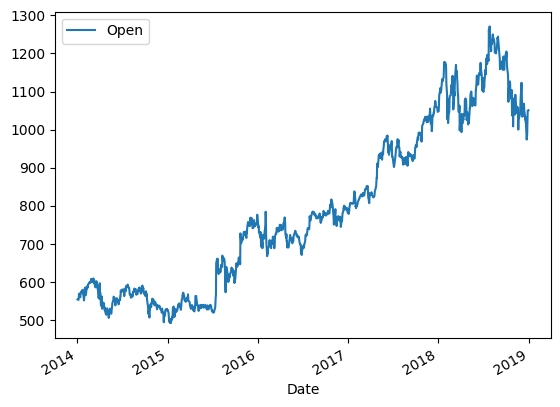

In [7]:
google.plot()
plt.show()

In [8]:
display(adfuller_test(google))
display(kpss_test(google))

ADF Statistic: -0.642239
p-value: 0.861149
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Result: The series is not stationary


None

KPSS Statistic: 5.449810701097353
p-value: 0.01
num lags: 21
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


C:\Users\nickc\AppData\Local\Temp\ipykernel_21660\1726548887.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


None

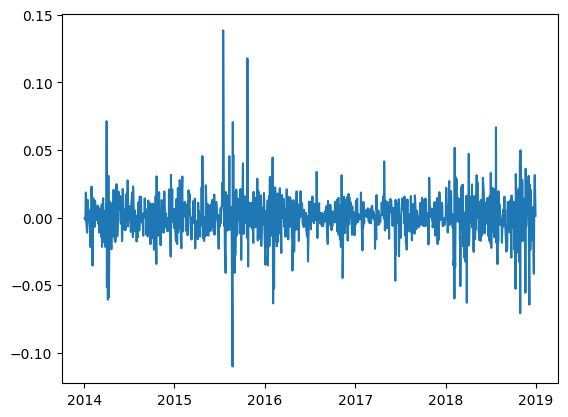

In [9]:
google_log = np.log(google)
google_log_diff = google_log.diff().dropna()
plt.plot(google_log_diff)
plt.show()

In [10]:
print(adfuller_test(google_log_diff))
print(kpss_test(google_log_diff))

ADF Statistic: -12.555178
p-value: 0.000000
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Result: The series is stationary
None
KPSS Statistic: 0.05074181530790068
p-value: 0.1
num lags: 9
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
None


C:\Users\nickc\AppData\Local\Temp\ipykernel_21660\1726548887.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(series, **kw)


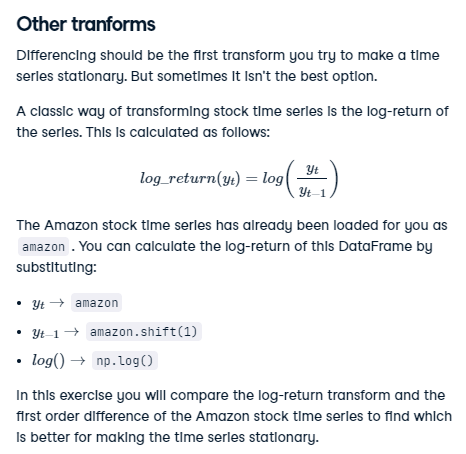

# FInd the Best Parameters for the ARIMA Models

In [81]:
order_aic_bic = []

for p in range(3) :
     for q in range(3) :
          model = ARIMA(google_log, order = (p,1,q)) # we know 1 order of differencing is needed
          results = model.fit()

          order_aic_bic.append((p,q, results.aic, results.bic))
          


c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.

In [82]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p','q','AIC','BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

print('*********************************')
# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

   p  q          AIC          BIC
8  2  2 -6891.626345 -6865.943929
3  1  0 -6883.800562 -6873.527596
1  0  1 -6883.504740 -6873.231774
2  0  2 -6882.329116 -6866.919666
6  2  0 -6882.059567 -6866.650117
4  1  1 -6881.929547 -6866.520097
5  1  2 -6880.232927 -6859.686994
7  2  1 -6880.097196 -6859.551263
0  0  0 -6877.931295 -6872.794811
*********************************
   p  q          AIC          BIC
3  1  0 -6883.800562 -6873.527596
1  0  1 -6883.504740 -6873.231774
0  0  0 -6877.931295 -6872.794811
2  0  2 -6882.329116 -6866.919666
6  2  0 -6882.059567 -6866.650117
4  1  1 -6881.929547 -6866.520097
8  2  2 -6891.626345 -6865.943929
5  1  2 -6880.232927 -6859.686994
7  2  1 -6880.097196 -6859.551263


In [83]:
model = ARIMA(google_log, order = (2,1,2))

result = model.fit()
print(result.summary())

c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 1258
Model:                 ARIMA(2, 1, 2)   Log Likelihood                3450.813
Date:                Thu, 29 Feb 2024   AIC                          -6891.626
Time:                        20:15:38   BIC                          -6865.944
Sample:                             0   HQIC                         -6881.974
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2798      0.065     -4.289      0.000      -0.408      -0.152
ar.L2         -0.8129      0.062    -13.121      0.000      -0.934      -0.691
ma.L1          0.2091      0.064      3.273      0.0

c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


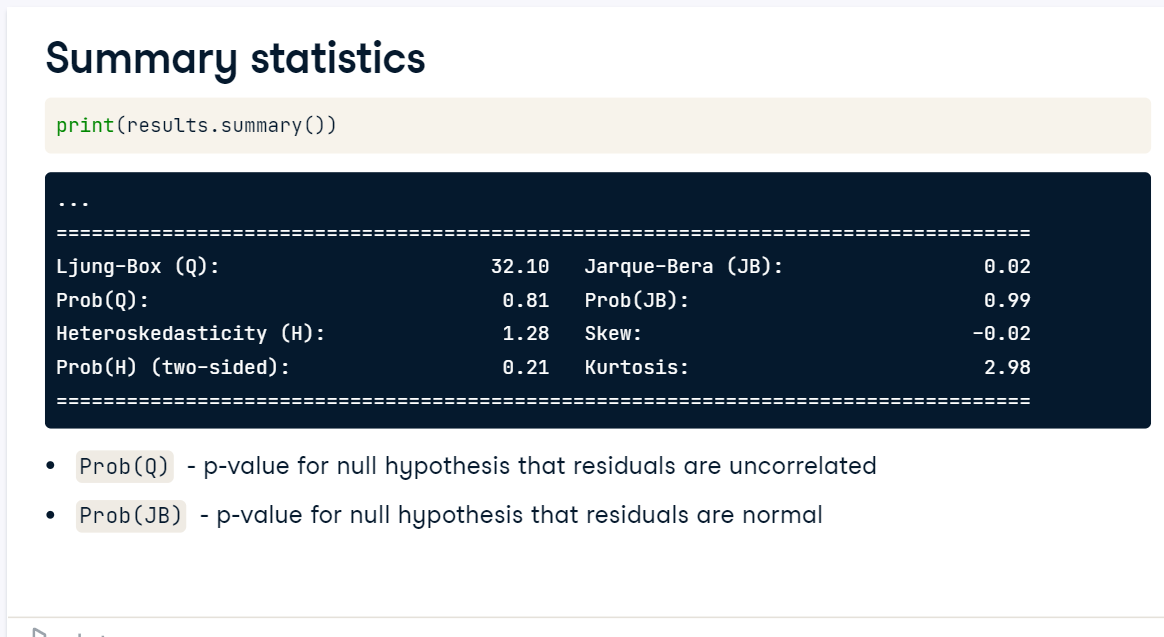

# Residual Analysis

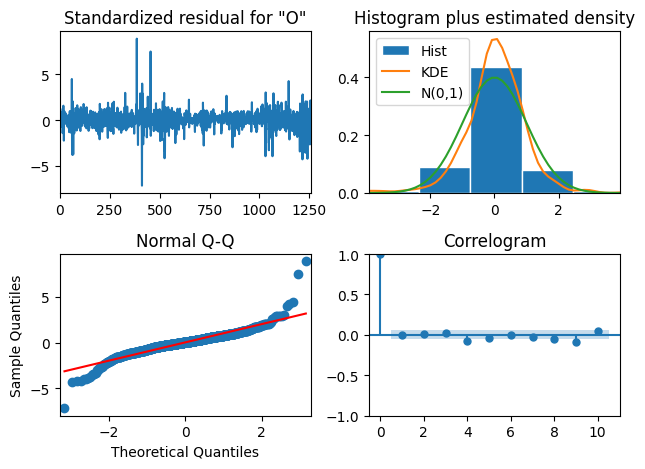

In [14]:
result.plot_diagnostics()
plt.tight_layout()
plt.show()

In [15]:
mae = np.mean(np.abs(result.resid))

print(f'MAE: {mae}')

MAE: 0.01564654735555415


# AUTO ARIMA

In [16]:
from pmdarima import plot_acf

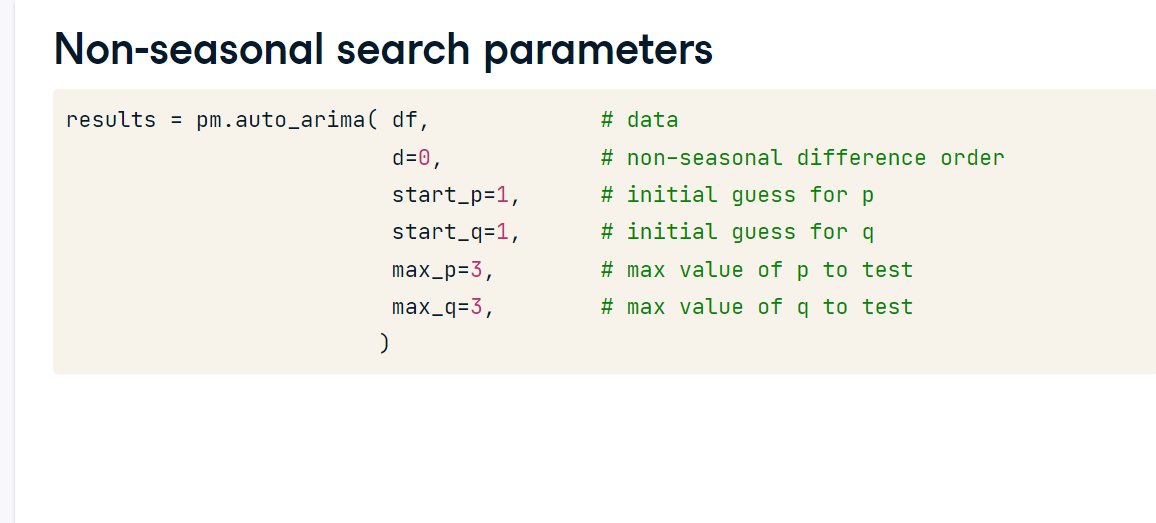

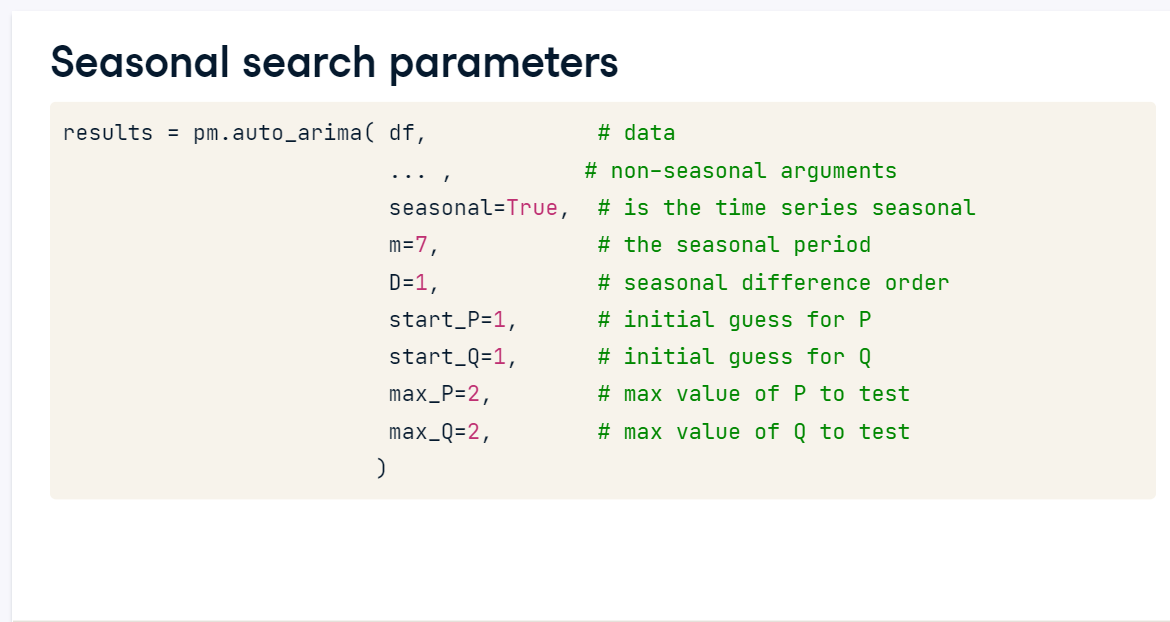

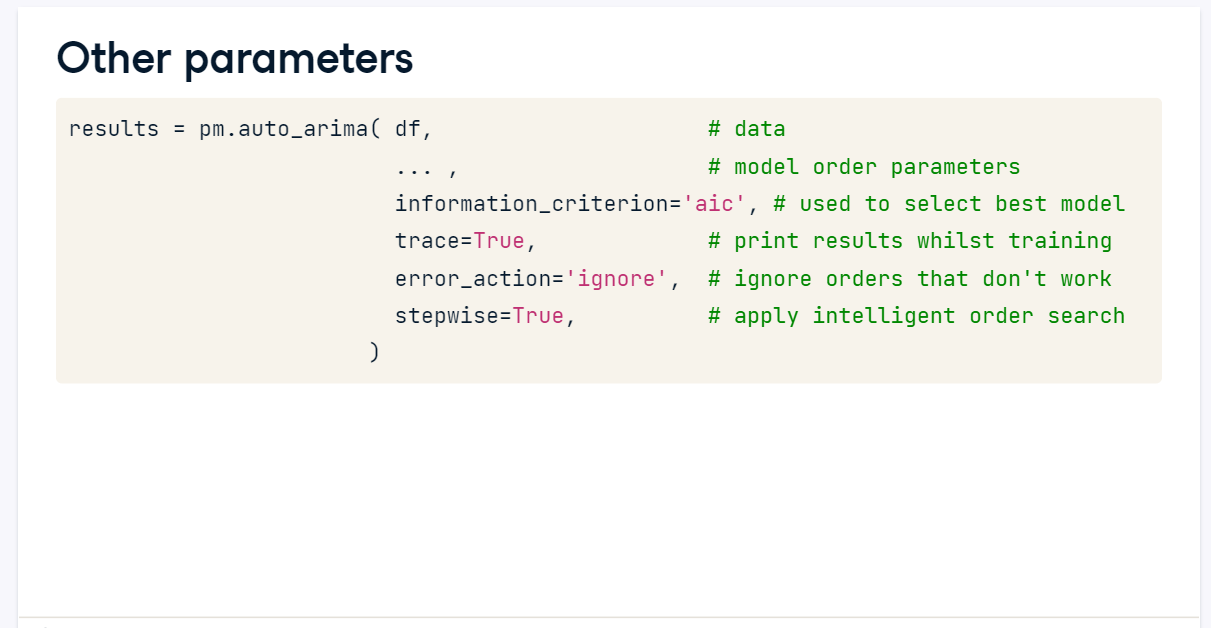

In [17]:
import pmdarima as pm

In [18]:
results = pm.auto_arima(google_log, 
                        information_criterion='aic',
                        trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6881.065, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6877.258, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6883.357, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6883.070, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6877.931, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6881.575, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6881.471, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6879.609, Time=0.70 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6883.801, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-6882.060, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6881.930, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-6883.505, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-6880.097, Time=0.19 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.921 seconds


In [19]:
results

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [20]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1258
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3443.900
Date:                Thu, 29 Feb 2024   AIC                          -6883.801
Time:                        15:03:56   BIC                          -6873.528
Sample:                             0   HQIC                         -6879.940
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0790      0.018     -4.428      0.000      -0.114      -0.044
sigma2         0.0002   3.78e-06     64.540      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

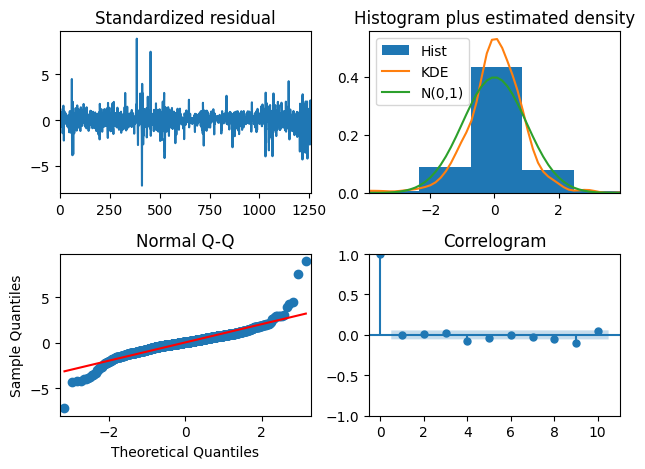

In [21]:
results.plot_diagnostics()
plt.tight_layout()
plt.show()

# Forecasting

## In Sample Forecasting 

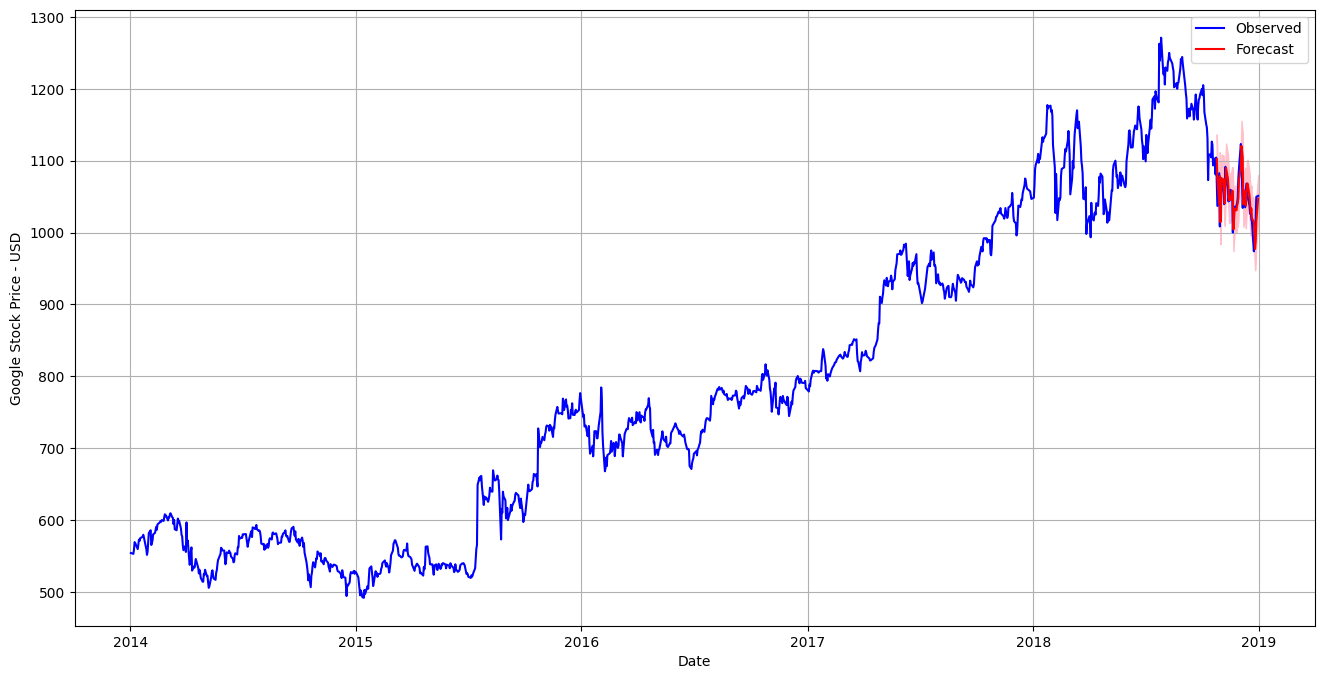

In [60]:
forecast = result.get_prediction(start =-45)
mean_forecast = forecast.predicted_mean

conf_int = forecast.conf_int()


lower_limits = conf_int.loc[:,'lower Open']
upper_limits = conf_int.loc[:,'upper Open']

plt.figure(figsize=(16,8))
plt.plot(google.index, google, color = 'blue', label = 'Observed')

plt.plot(mean_forecast.index, np.exp(mean_forecast), color = 'red', label = 'Forecast')

plt.fill_between(lower_limits.index, np.exp(lower_limits), np.exp(upper_limits), color = 'pink')

plt.xlabel('Date')
plt.ylabel('Google Stock Price - USD')
plt.legend()
plt.grid(True)
plt.show()

## Dynamic Forecasting

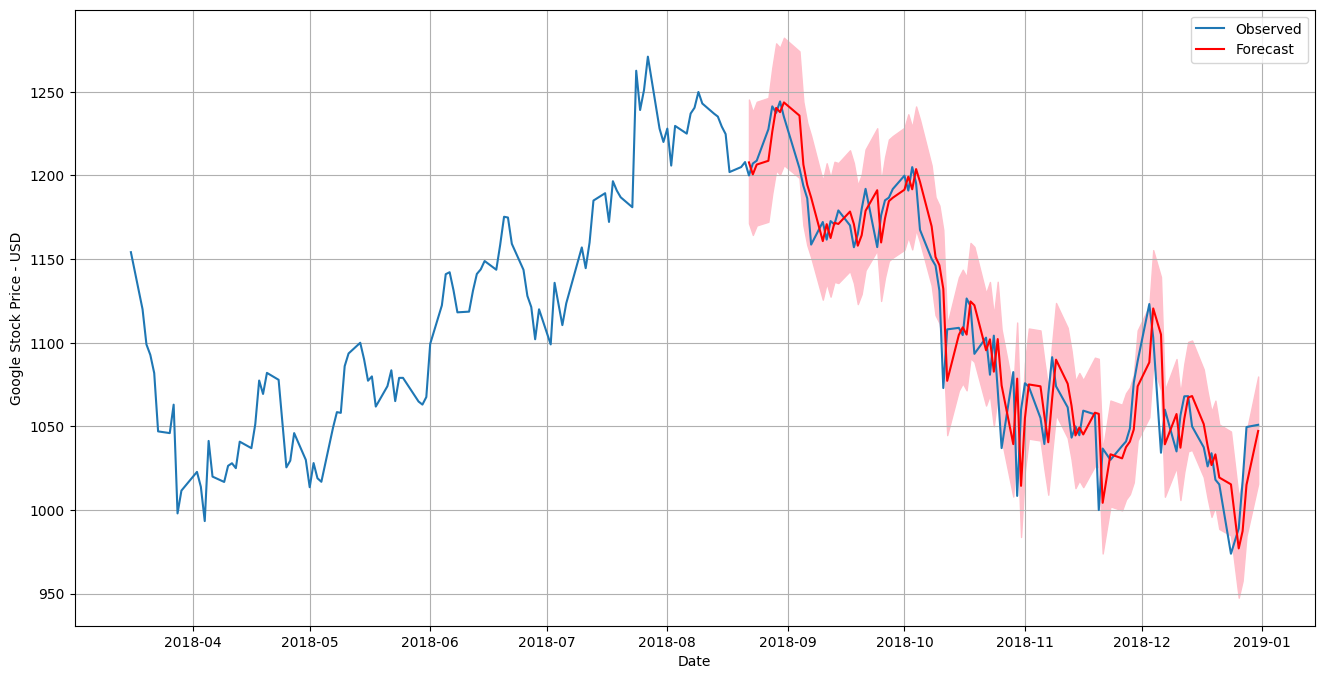

In [52]:
forecast = result.get_prediction(start =-90, dynamic = False)
mean_forecast = forecast.predicted_mean

conf_int = forecast.conf_int()


lower_limits = conf_int.loc[:,'lower Open']
upper_limits = conf_int.loc[:,'upper Open']
plt.figure(figsize = (16,8))
plt.plot(google.index[-200:], google[-200:], label = 'Observed')

plt.plot(mean_forecast.index, np.exp(mean_forecast), color = 'red', label = 'Forecast')

plt.fill_between(lower_limits.index, np.exp(lower_limits), np.exp(upper_limits), color = 'pink')

plt.xlabel('Date')
plt.ylabel('Google Stock Price - USD')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
y = google[google.index >= '2018-10-25']

In [72]:
prediction = np.exp(mean_forecast)

In [80]:
from sklearn.metrics import mean_absolute_error


mse = mean_squared_error(y, prediction)
print('MSE: '+str(mse))

rmse = math.sqrt(mean_squared_error(y, prediction))
print('RMSE: '+str(rmse))

mae = mean_absolute_error(y, prediction)
print('MAE: '+str(mae))

mape = mean_absolute_percentage_error(y, prediction)
print('MAPE:'+str(mape))


MSE: 736.607766564463
RMSE: 27.140518907428113
MAE: 21.296959913103482
MAPE:0.020383501340318882


## Out Sample Forecasting 

In [56]:
arima_value_forecasting = results.predict(60)

c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\nickc\DataScience\ds_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [53]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math


train_data, test_data = google[0:int(len(google)*0.8)], google[int(len(google)*0.8):]


train_arima = train_data['Open']
test_arima = test_data['Open']


history = [x for x in train_arima]
y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit()
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])

C:\Users\nickc\AppData\Local\Temp\ipykernel_21660\1628111302.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  history.append(y[0])


# Generic ARIMA Forecasting

# Rolling ARIMA Forecasting

In [37]:
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)

C:\Users\nickc\AppData\Local\Temp\ipykernel_21660\1295931633.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = y[i]


In [38]:
mean_absolute_percentage_error(y, predictions)

0.01452699433119438

In [39]:
# report performance
mse = mean_squared_error(y, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(y, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y, predictions))
print('RMSE: '+str(rmse))

MSE: 447.112865610459
MAE: 15.942807574495335
RMSE: 21.14504352349408


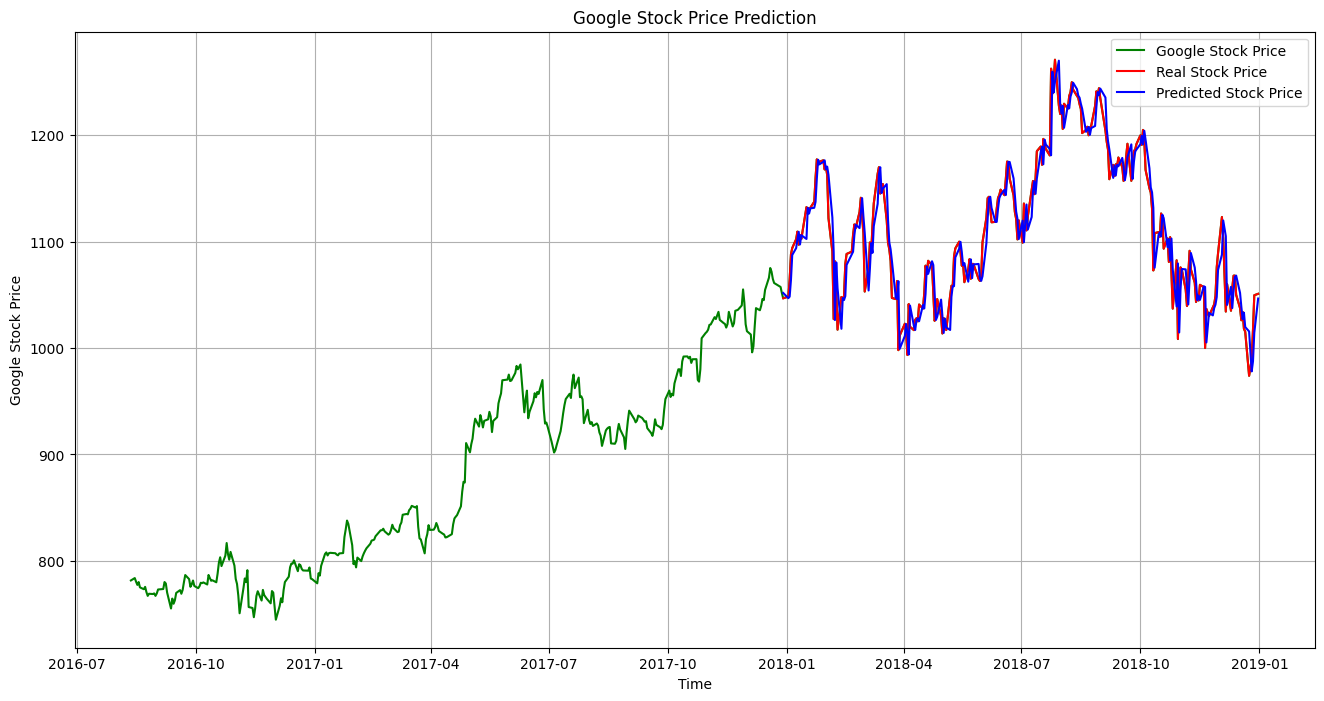

In [28]:
plt.figure(figsize=(16,8))
plt.plot(google.index[-600:], google['Open'].tail(600), color='green', label = 'Google Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.grid(True)
plt.show()